
## Generalized Advantage Estimation in Reinforcement Learning

### References:
[1] Schulman, J., Moritz, P., Levine, S., Jordan, M., & Abbeel, P. (2015). High-dimensional continuous control using generalized advantage estimation. arXiv preprint arXiv:1506.02438.


[2] The code in this notebook demo is adapted based on - https://colab.research.google.com/drive/1Wb_2zKgAqhI2tVK19Y1QC8AHImrzlcme?usp=sharing


#### **Problem Setting**

In this notebook, we consider a typical formulation of the policy optimization problem. The initial state $s_0$ is sampled from initial distribution $p_0$. A trajectory $(s_0, a_0, s_1, s_0, ...)$ is generated by sampling from policy $\pi(a_t|s_t)$. The states then transition from $s_t$ to $s_{t+1}$ from a sampled distribution of $P(s_{t+1}|s_t, a_t)$. A reward $r_t = r(s_t, a_t, s_{t+1})$ is dispensed at each time stamp. The goal is to maximize the expected total reward $\sum_{t=0}^{\infty}r_t$, which is assumed to be finite for all policies in this problem setting. 

Moreover, in this problem, we are not assuming a discount as part of the problem specification. It appears to be a controllable parameter that adjusts bias-variance tradeoff.

Policy gradient methods maximizes the expected total reward by estimating the policy gradient at each time stamp. The gradient which points to the direction where parameter $\theta$ in the policy term $\pi_\theta(a_t|s_t)$ is hard to be computed through a closed-form expression. We aim to demonstrate a method of estimating the policy gradient empirically through a set of trajectories.


#### **Policy Gradient**

We can be represented by

$$ g = \triangledown_{\theta} E[\sum_{t=0}^{\infty} r_t]. $$

The estimation of policy gradient through a set of trajectories is one of the most fundamental problems. In this problem settig, we assume that the policy gradient possess the following particular form:

$$ g = E[\sum_{t=0}^{\infty} A^{\pi}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)], $$

where $A^{\pi}$ is the advantage of $(a_t, s_t)$ in comparisons to the average value function $V^{\pi}(s_t) = E_{s_{t+1}:\infty, a_t:\infty}[\sum_{l=0}^{\infty}r_{t+l}]$.

That is, $A^{\pi}(s_t, a_t) = Q^{\pi}(s_t, a_t) - V^{\pi}(s_t),$

where $Q^{\pi}(s_t, a_t) = E_{s_{t+1}:\infty, a_{t+1}:\infty}[\sum_{l=0}^{\infty}r_{t+l}]$. 

The difference between $Q^{\pi}(s_t, a_t)$ and $V^{\pi}(s_t)$ is that $Q^{\pi}(s_t, a_t)$ the expected return across all rollouts after taking action $a_t$ at $s_t$ whereas $V^{\pi}(s_t)$ is the expected return across all actions taken in $s_t$ resulting all subsequential rollouts. The advantage function is therefore the "advantage" of taking a specific action $a_t$ at $s_t$ in comparison to the average overall return of all actions to be taken at $s_t$.

The selection of $A^{\pi}(s_t, a_t)$ term as part of the policy gradient ensures that the gradient points in the direction of increased $\pi_{\theta}(a_t|s_t)$ if and only if $A^{\pi}(s_t, a_t) > 0$.

#### **Approximation of Policy Gradient**

We can introduce a parameter $\gamma$ in the estimation of $g$, denoted as $g^{\gamma}$, to control the bias-variance tradeoff in the estimation.

$$ g^{\gamma} = E[\sum_{t=0}^{\infty} A^{\pi, \gamma}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)], $$

where $A^{\pi, \gamma}(s_t, a_t)$ is the discounted advantage function, which has form as

$$A^{\pi, \gamma}(s_t, a_t) = Q^{\pi, \gamma}(s_t, a_t) - V^{\pi, \gamma}(s_t).$$

$Q^{\pi, \gamma}(s_t, a_t), V^{\pi, \gamma}(s_t)$ are the discounted version of $Q^{\pi}(s_t, a_t), V^{\pi}(s_t)$, i.e.,

$$Q^{\pi, \gamma}(s_t, a_t) = E_{s_{t+1:\infty}, a_{t+1:\infty}}[\sum_{l=0}^\infty\gamma^l r_{t+l}]$$ 

,and

$$V^{\pi, \gamma}(s_t) = E_{s_{t+1:\infty}, a_{t:\infty}}[\sum_{l=0}^\infty\gamma^l r_{t+l}].$$


They have the exact same form as in the literature of discounted return in Reinforcement Learning. However, in this context, the purpose of the parameter $\gamma$ is to control the variability of value function at any state $s_t$ by introducing bias term.

Based on the above estimator $g^{\gamma}$, we want to estimate $g^{\gamma}$.


#### **Generalized Estimator of Advantage**

The target of Generalized Estimator of Advantage is to have

$$\hat{A}_t(s_{0:\infty}, a_{0;\infty})$$

such that 

$$E_{s_0:\infty,a_0:\infty}[\sum_{t=0}^{\infty}\hat{A}_t(s_{0:\infty}, a_{0;\infty})\triangledown_\theta log \pi_{\theta}(a_t | s_t)] = E[\sum_{t=0}^{\infty} A^{\pi, \gamma}(s_t, a_t) \triangledown_\theta log \pi_{\theta}(a_t | s_t)].$$

Note that we already introduced bias to the estimation of policy gradient when we replace $A^{\pi}$ by $A^{\pi, \gamma}$. Here we only consider an unbiased estimator of $g^{\gamma}$, which is a biased estimate of policy gradient of undiscounted MDP.

Suppose that $V$ is an approximate value function, we define TD residuals $\delta_t^V = r_t + \gamma V(s_{t+1}) - V(s_t)$ where $\gamma$ is the discount factor. $\delta_t^V$ can be considered as an estimate of the advantage of the action $a_t$. If we have the correct value function $V = V^{\pi, \gamma}$, we can easily show that 

$$E_{s_{t+1}}[\delta_t^{V^{\pi, \gamma}}] = E_{s_{t+1}}[Q^{\pi,\gamma}(s_t,a_t) - V^{\pi, \gamma}(s_t)] = A^{\pi, \gamma}(s_t, a_t).$$

However, it is not unbiased estimator if $V \neq V^{\pi, \gamma}$, which means that using TD residual would introduce bias unless we know the exact value function.

Consider a general $k$ sums of these TD residuals,

$$\hat{A}_t^{(1)} = \delta_t^V = -V(s_t) + r_t + \gamma V(s_{t+1})$$
$$\hat{A}_t^{(2)} = \delta_t^V + \gamma \delta_{t+1}^V = -V(s_t) + r_t + \gamma r_{t+1} + \gamma^2 V(s_{t+1})$$
$$\hat{A}_t^{(k)} = \sum_{l=0}^{k-1} \gamma^l \delta_{t+l}^V = -V(s_t) + r_t + \gamma r_{t+1} + ... + \gamma^{k-1} r_{t+k-1} + \gamma^kV(s_{t+k})$$

An importan obervasion is that as $k$ becomes larger, the bias introduced by inaccurate value function $V$ gets smaller and smaller. As $k \rightarrow \infty$,

$$\hat{A}_t^{\infty} = \sum_{l=0}^{\infty} \gamma^l \delta_{t+l}^V = -V(s_t) + \sum_{l=0}^{\infty} \gamma^l r_{t+l}.$$

Recall that $A^{\pi, \gamma} = Q^{\pi, \gamma}(s_t,a_t) - V^{\pi, \gamma}(s_t) = E_{s_{t+1:\infty}, a_{t+1:\infty}}[\sum_{l=0}^{\infty} \gamma^l r_{t+l}] - V^{\pi, \gamma}(s_t)$.

Comparing these two above equations, we can find that taking expectation of $\hat{A}_t^{\infty}$ would result in expectation of $A^{\pi, \gamma}$, regardless of the choice of $V$ by Proposition 1 in the paper.

**Prop. 1** Suppose that $\hat{A}_t$ can be written in the form $\hat{A}_t(s_{0:\infty},a_{0:\infty}) = Q_t(s_{t:\infty}, a_{t:\infty}) - b_t(s_{0:t}, a_{0:{t-1}})$ such that for all $(s_t, a_t)$, $E_{s_{t+1:\infty},a_{t+1:\infty}}[Q_t(s_{t:\infty},a_{t:\infty})] = Q^{\pi, \gamma}(s_t, a_t). Then, E_{s_{0:\infty},a_{0:\infty}}[\hat{A}_t(s_{0:\infty},a_{0:\infty})] = E_{s_{0:\infty},a_{0:\infty}}[A^{\pi, \gamma}(s_t,a_t)]$.

To further control the bias-varaince tradeoff with estimator $A^{\infty}_t$
Therefore, an enhancement of the above estimator is to use exponentially-weighted sum of $k$-step estimator:

$$\hat{A}^{GAE(\gamma,\lambda)} = (1-\lambda)(\hat{A}^{(1)}_t + \lambda \hat{A}^{(2)}_t + ...) = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V$$

Note that when $\lambda = 0$, $\hat{A}^{GAE(\gamma,0)}$ is reduced to $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$, which as discussed above is biased unless $V = V^{\pi, \gamma}$. When $\lambda = 1$, $\hat{A}^{GAE(\gamma,0)} = A_t^{\infty}$ which has expectation equal to the expectation of $A^{\pi, \gamma}$.


**Some Transition Dynamics**

Here we demonstrate our findings with the estimator $A^{\pi, \gamma}(s_t, a_t)$ for $A^{\pi}(s_t, a_t)$, and estimator $\hat{A}^{GAE(\gamma, \lambda)}$ for $A^{\pi, \gamma}(s_t, a_t)$ in a simple set up.

We will use an episodic five state chain environment. At the beginning of an episode, the agent starts in state $s_1$. In each state, it can take an action $a \in \{\texttt{left}, \texttt{right}\}$ which will deterministically move it into the corresponding next state. When the agent reaches either one of states $s_0$ or $s_6$ the episode ends. The agent receives zero rewards at all transitions, except when it takes the $\texttt{right}$ action in state $s_5$ where it receives a reward of one. Throughout the notebook, we use $\mathcal{S} = \{s_0, s_1, s_2, s_3, s_4, s_5, s_6\}$ to denote the state set and $\mathcal{A} = \{\texttt{left}, \texttt{right}\}$ to denote the action set.



# Environment: Linear Chain
We will use an episodic five state chain environment, as shown **below**. At the beginning of an episode, the agent starts in state $s_1$. In each state, it can take an action $a \in \{\texttt{left}, \texttt{right}\}$ which will deterministically move it into the corresponding next state. When the agent reaches either one of states $s_0$ or $s_6$ the episode ends. The agent receives zero rewards at all transitions, except when it takes the $\texttt{right}$ action in state $s_5$ where it receives a reward of one. Throughout the notebook, we use $\mathcal{S} = \{s_0, s_1, s_2, s_3, s_4, s_5, s_6\}$ to denote the state set and $\mathcal{A} = \{\texttt{left}, \texttt{right}\}$ to denote the action set.

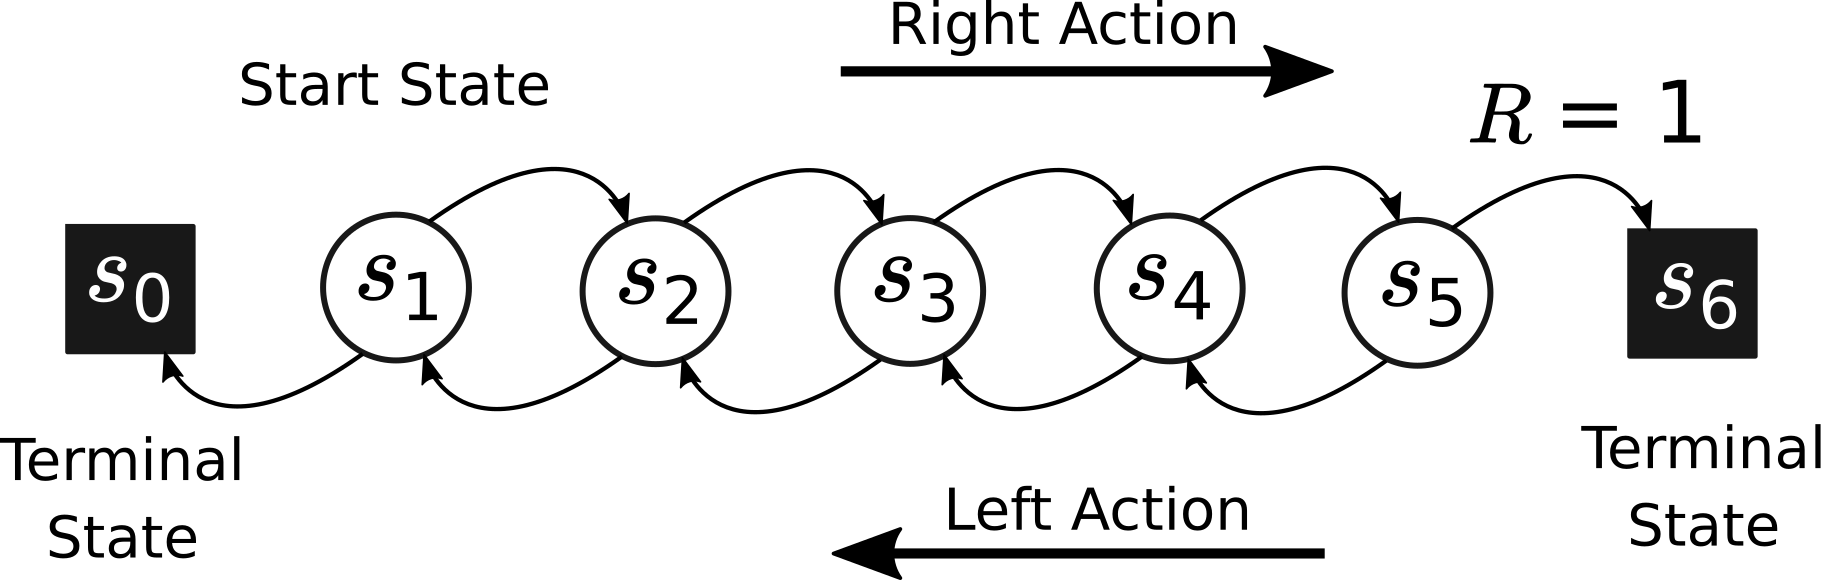

## Matrices $\boldsymbol{P}, \boldsymbol{r}$, and $\boldsymbol{\pi}$

* $\boldsymbol{P}$ is the transition probability matrix. It is a 3D matrix of size $|\mathcal{A}| \times |\mathcal{S}| \times |\mathcal{S}|$, where the $(i, j, k)$th element corresponds to $\Pr\{S_{t+1} = s_k \;|\; S_t = s_j, A_t = a_i\}$.

* $\boldsymbol{r}$ is the reward matrix of size $|\mathcal{S}| \times |\mathcal{A}|$ where the $(i, j)$th element is equal to $r(s_i, a_j)$.

* $\boldsymbol{\pi}$ is a matrix, of size $|\mathcal{S}| \times |\mathcal{A}|$, representing the policy of the agent where the $(i, j)$th element is equal to $\pi(a_j|s_i)$.

We will later pass the matrices $\boldsymbol{P}$ and $\boldsymbol{r}$ to define the `LinearChain()` environment. 

For a detailed introduction to vector notation in RL, please see (Agarwal et al., 2020).

In [24]:
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import chain

In [25]:
P = np.array([[[1, 0, 0, 0, 0, 0, 0],    # s_0 terminal \
               [1, 0, 0, 0, 0, 0, 0],    # s_1           |
               [0, 1, 0, 0, 0, 0, 0],    # s_2           |
               [0, 0, 1, 0, 0, 0, 0],    # s_3           |-> for action a_0 i.e. left          
               [0, 0, 0, 1, 0, 0, 0],    # s_4           |
               [0, 0, 0, 0, 1, 0, 0],    # s_5           |
               [0, 0, 0, 0, 0, 0, 1]],   # s_6 terminal /
              
              [[1, 0, 0, 0, 0, 0, 0],    # s_0 terminal \
               [0, 0, 1, 0, 0, 0, 0],    # s_1           |
               [0, 0, 0, 1, 0, 0, 0],    # s_2           |
               [0, 0, 0, 0, 1, 0, 0],    # s_3           |-> for action a_1 i.e. right
               [0, 0, 0, 0, 0, 1, 0],    # s_4           |
               [0, 0, 0, 0, 0, 0, 1],    # s_5           |
               [0, 0, 0, 0, 0, 0, 1]]])  # s_6 terminal /
#  State:       0  1  2  3  4  5  6

r = np.array([[0, 0],  # s_0
              [0, 0],  # s_1
              [0, 0],  # s_2
              [0, 0],  # s_3
              [0, 0],  # s_4
              [0, 1],  # s_5
              [0, 0]]) # s_6
# Action:    a_0  a_1

pi = np.array([[0.5, 0.5],  # s_0
               [0.5, 0.5],  # s_1
               [0.5, 0.5],  # s_2
               [0.5, 0.5],  # s_3
               [0.5, 0.5],  # s_4
               [0.5, 0.5],  # s_5
               [0.5, 0.5]]) # s_6
# Action:       a_0  a_1

tabular_features = np.array([[0, 0, 0, 0, 0],  # s_0 terminal
                             [1, 0, 0, 0, 0],  # s_1
                             [0, 1, 0, 0, 0],  # s_2  
                             [0, 0, 1, 0, 0],  # s_3
                             [0, 0, 0, 1, 0],  # s_4
                             [0, 0, 0, 0, 1],  # s_5
                             [0, 0, 0, 0, 0]]) # s_6 terminal

Given a linear chain, the step function will calculate the next stochastic state and reward automatically based on the action and the transition dynamics.

In [26]:
class LinearChain():
    def __init__(self, P, r, start_state, terminal_states, noise=0):
        self.P = P
        self.r = r
        self.noise = noise
        self.n = P.shape[-1]
        self.start_state = start_state
        self.terminal_states = terminal_states

        self.observation_space = self.n
        self.action_space = 2
        self.state = None

        self.t = 0

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        if self.state is None:
            raise Exception('step() used before calling reset()')
        assert action in range(P.shape[0])

        reward = r[self.state, action] \
            + np.random.normal(loc=0, scale=self.noise)
        self.state = np.random.choice(a=self.n, p=self.P[action, self.state])
        self.t = self.t + 1

        done = False
        if self.state in self.terminal_states:
            done = True

        return self.state, reward, done, {}

    def calc_v_pi(self, pi, gamma):
        # calculate P_pi from the transition matrix P and the policy pi
        P_pi = np.zeros(self.P[0].shape)
        for a in range(pi.shape[1]):
            P_pi += self.P[a] * pi[:, a].reshape(-1, 1)

        # calculate the vector r_pi
        r_pi = (self.r * pi).sum(1).reshape(-1, 1)

        # calculate v_pi using the equation given above
        v_pi = np.matmul(
            np.linalg.inv(np.eye(self.P.shape[-1]) - gamma * P_pi), 
            r_pi)

        return v_pi

    # Calculate the ground truth state-action value function based on the 
    # ground truth state value function.
    def calc_q_pi(self, pi, gamma):
        # First calcuate the ground truth value vector.
        v_pi = self.calc_v_pi(pi, gamma)
        q_pi = self.r + gamma * (self.P @ v_pi)[:, :, 0].T
        return q_pi

In [27]:
class Agent():

    def __init__(self, num_actions, policy_features, value_features,
                 policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                 FLAG_BASELINE, FLAG_POPULAR_PG=False):
        self.policy_features = policy_features
        self.value_features = value_features
        self.num_actions = num_actions

        self.policy_weight = np.zeros((policy_features.shape[1],
                                       num_actions))
        if value_features is None:
            self.value_weight = None
        else:
            self.value_weight = np.zeros((value_features.shape[1], 1))

        self.policy_stepsize = policy_stepsize
        self.value_stepsize = value_stepsize

        self.FLAG_BASELINE = FLAG_BASELINE
        self.FLAG_POPULAR_PG = FLAG_POPULAR_PG
        self.gamma = gamma
        # Parameter for calculating the generalized advantage.
        self.lambda_ = lambda_
        self.nstep = nstep
        # Create parameters for containing estimated advantages and unbiased 
        # advantages.
        self.advantage_estimation = []
        self.unbiased_advantage = []
        self.bias_11 = []
        self.bias_51 = []

        self.pi = None
        self.FLAG_POLICY_UPDATED = True

    @staticmethod
    def softmax(x):
        e_x = np.exp(x - np.max(x, 1).reshape(-1, 1))
        out = e_x / e_x.sum(1).reshape(-1, 1)
        return out

    # At a given state, use the existing stochastic policy to decide which 
    # action to take.
    def take_action(self, state):
        if self.FLAG_POLICY_UPDATED:
            action_prefs = np.matmul(self.policy_features, self.policy_weight)
            self.pi = self.softmax(action_prefs)
            self.FLAG_POLICY_UPDATED = False
            
        action = np.random.choice(self.num_actions, p=self.pi[state])
        return action, self.pi[state, action]

    # Use the current value functions to make predictions.
    def calc_v_pi_pred(self):
        return np.matmul(self.value_features, self.value_weight)

    # =========================================================================
    # Calculate the advantage for a specific step.
    def calc_TD(self, curr_state, next_state, reward):
        return reward + (self.value_features[next_state] @ self.value_weight - \
                         self.value_features[curr_state] @ self.value_weight)

    # Calculate GAE based on infinite horizon with absorbing states (s_0 and 
    # s_6). In the absorbing states though, the value function and the reward 
    # stay to be 0 and thus the TD at each absorbing step is also 0.
    def calc_generalized_advantage(self, t, traj, v_pi, q_pi):
        reward_list = traj['reward_list']
        next_state_list = traj['next_state_list']
        state_list = traj['state_list']
        action_list = traj['action_list']
        traj_length = len(reward_list)

        GAE = 0
        discount = 1
        for i in range(t, traj_length):
            GAE += discount * self.calc_TD(state_list[i], 
                                           next_state_list[i], 
                                           reward_list[i])
            discount *= self.gamma * self.lambda_

        # Calculate the ground truth unbiased advantage based on the ground
        # truth state action value function and state value function.
        true_advantage = q_pi[state_list[t], action_list[t]] - \
                         v_pi[state_list[t]]

        if state_list[t] == 1 and action_list[t] == 1:
            self.bias_11.append(abs(GAE - true_advantage))
        elif state_list[t] == 5 and action_list[t] == 1:
            self.bias_51.append(abs(GAE - true_advantage))
            
        return GAE, true_advantage
    # =========================================================================
    
    def calc_nstep_return(self, t, traj, v_pi):
        reward_list = traj['reward_list']
        next_state_list = traj['next_state_list']
        traj_length = len(reward_list)

        nstep = self.nstep
        assert nstep  == 'inf' or nstep > 0
        if nstep == 'inf' or nstep > traj_length:
            nstep = traj_length

        nstep_return = 0
        discount = 1
        for i in range(t, min(t+nstep, traj_length)):
            nstep_return += discount * reward_list[i]
            discount *= self.gamma
        i = min(t+nstep, traj_length) - 1
        nstep_return += discount * v_pi[next_state_list[i]]
            
        return nstep_return

    # Using the difference between the accumulated n-step reward and the estimated
    # value predicted by the value function, update the value function parameter.
    def update_value_fn(self, traj):
        state_list = traj['state_list']
        traj_length = len(state_list)

        for t in range(traj_length):
            state = state_list[t]
            v_pi = self.calc_v_pi_pred()
            G = self.calc_nstep_return(t, traj, v_pi)
                    
            v_pred = v_pi[state]
            self.value_weight = self.value_weight \
                + self.value_stepsize * (G - v_pred) \
                * self.value_features[state].reshape(self.value_weight.shape)

    # helper function for calculating the policy gradient.
    def calc_grad_log_pi(self, state, action):
        x = self.policy_features[state].reshape(-1, 1)
        action_prefs = np.matmul(x.T, self.policy_weight)
        pi = self.softmax(action_prefs).T

        I_action = np.zeros((self.num_actions, 1))
        I_action[action] = 1

        one_vec = np.ones((1, self.num_actions))

        return np.matmul(x, one_vec) * (I_action - pi).T

    # Calculate the REINFORCE based policy gradient.
    def calc_reinforce_pg(self, traj, v_pi, q_pi):
        state_list = traj['state_list']
        action_list = traj['action_list']
        traj_length = len(state_list)
        
        policy_grad = np.zeros(self.policy_weight.shape)
        GAEs, advantages = [], []
        for t in range(traj_length):
            state = state_list[t]
            action = action_list[t]
            GAE, true_advantage = self.calc_generalized_advantage(t, traj, v_pi, q_pi)
            GAEs.append(GAE)
            advantages.append(true_advantage)
            grad_log_pi = self.calc_grad_log_pi(state, action)
            
            if self.FLAG_BASELINE:
                baseline = v_pi[state]
            else:
                baseline = 0

            # if self.FLAG_POPULAR_PG == False:
            #     policy_grad += self.gamma**t * GAE * grad_log_pi
            # else:
            #     policy_grad += GAE * grad_log_pi
            policy_grad += GAE * grad_log_pi
        # Add the info for each episode separately into the object.
        self.advantage_estimation.append(GAEs)
        self.unbiased_advantage.append(advantages)

        return policy_grad

    # Use the policy gradient to update the policy function.
    def update_policy(self, traj, v_pi, q_pi):
        policy_grad = self.calc_reinforce_pg(traj, v_pi, q_pi)
        
        self.policy_weight = self.policy_weight \
            + self.policy_stepsize * policy_grad

        self.FLAG_POLICY_UPDATED = True

    def plot_advantage(self):
        x = list(range(len(list(chain.from_iterable(self.advantage_estimation)))))
        GAEs = list(chain.from_iterable(self.advantage_estimation))
        true_advantages = list(chain.from_iterable(self.unbiased_advantage))
        bias = [GAEs[i] - true_advantages[i] for i in range(len(GAEs))]
        # plt.plot(x, GAEs, label="GAE")
        # plt.plot(x, true_advantages, label="unbiased_advantage")
        plt.plot(x, bias, label="bias")
        plt.legend()
        plt.show()

    # Calculate the bias and variance across the first steps of the episodes 
    # for this run.
    def variance(self):
        GAEs = [episode[0] for episode in self.advantage_estimation]
        advantages = [episode[0] for episode in self.unbiased_advantage]
        variance = np.var(np.asarray(GAEs))
        return variance




The algorithm for calculating GAE at each time step of the trajectory is as follows:

For each $run$ and each $gamma$
>Loop for $num\_episodes$


>> Sample an episode $S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_T, S_T$ from the environment using the policy $\pi_\boldsymbol{\theta}$

>> For each step of the episode $t = 0, 1, \ldots, T-1$:

>>> Ccalculate: **a**. GAE based on the infinite horizon, i.e., $\hat{A}^{GAE(\gamma,\lambda)}(a_t) = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l}^V$; **b**. The ground truth advantage, i.e., $Q^{\pi, \gamma}(s_t, a_t) - V^{\pi, \gamma}(s_t)$ (using the ground truth state value function and state-action value function)


>>> Calculate the $n$-step return $G_{t:t+n}$

>>> Update the value function using the $n$-step TD update $\boldsymbol{w_{\text{new}}} \leftarrow \boldsymbol{w_{\text{old}}} + \alpha_{\boldsymbol{w}} (G_{t:t+n} - \hat{v}_\boldsymbol{w}(S_t)) \boldsymbol{\phi}(S_t)$ 


>> Based on the GAEs along the trajectory, calculate the policy gradient estimate $\nabla_{\boldsymbol{\theta}} 
J = \sum_{t=0}^{\infty} \left\{\left[\hat{A}^{GAE(\gamma,\lambda)}(a_t)\right] \nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(A_t | S_t)\right\}$

>> Update the policy using $\boldsymbol{\theta}_\text{new} \leftarrow \boldsymbol{\theta}_\text{old} + \alpha_{\boldsymbol{\theta}} \nabla_{\boldsymbol{\theta}} J$.
---


**Note:** This exact order of first updating the policy and then the value function is important. Doing the updates in the reverse order can give rise to problems (for details, refer slide 25 in [Martha's presentation](https://drive.google.com/file/d/12w3EHzgE6CNaBhjPrqJO7IDY7WCnWBPW/view?usp=sharing))

In [28]:
def run_experiment(num_runs, num_episodes,
                   P, r, start_state, terminal_state,
                   num_actions, policy_features, value_features,
                   policy_stepsize, value_stepsize, nstep, lambdas, gamma,
                   FLAG_BASELINE, FLAG_LEARN_VPI, reward_noise=0, vpi_bias=0):
    return_across_runs = []
    ep_len_across_runs = []
    vpi_across_runs = []

    for run in range(num_runs):
        for lambda_ in lambdas:
            print(run)
            np.random.seed(run) 

            # define agent and the environment
            env = LinearChain(P, r, start_state, terminal_states, reward_noise)

            agent = Agent(num_actions, policy_features, value_features,
                        policy_stepsize, value_stepsize, nstep, lambda_, gamma,
                        FLAG_BASELINE)

            return_across_episodes = []
            ep_len_across_episodes = []
            vpi_across_episodes = []

            episode = 0
            while episode < num_episodes:
                episode += 1

                traj = {'state_list': [],
                        'action_list': [],
                        'action_prob_list': [],
                        'reward_list': [],
                        'next_state_list': []}

                # sample a trajectory from following the current policy
                done = False
                state = env.reset()
                while not done:
                    action, action_prob = agent.take_action(state)
                    next_state, reward, done, _ = env.step(action)

                    traj['state_list'].append(state)
                    traj['action_list'].append(action)
                    traj['action_prob_list'].append(action_prob)
                    traj['reward_list'].append(reward)
                    traj['next_state_list'].append(next_state)

                    state = next_state

                # # evaluate the current policy pi
                # if FLAG_LEARN_VPI:
                #     v_pi = agent.calc_v_pi_pred() + vpi_bias
                # else:
                #     v_pi = env.calc_v_pi(agent.pi, gamma)
                
                # Set v_pi to always be the ground truth. Since in the GAE setting, 
                # estimated v_pi can be calculated using the newly defined helper 
                # function `cal_TD`, so the ground truth v_pi can be used to 
                # calculate the ground truth unbiased advantage, for the later use
                # of bias-variance calculation.
                v_pi = env.calc_v_pi(agent.pi, gamma)
                q_pi = env.calc_q_pi(agent.pi, gamma)
                # print(q_pi.shape)


                # update the policy
                agent.update_policy(traj, v_pi, q_pi)

                # update the value function
                if FLAG_LEARN_VPI:
                    agent.update_value_fn(traj)

                # save the returns for this episode
                factor = 1
                discounted_return = 0
                for reward in traj['reward_list']:
                    discounted_return += factor * reward
                    factor *= gamma
                expected_ret = env.calc_v_pi(agent.pi, gamma)[start_state].item()

                return_across_episodes.append(discounted_return)
                ep_len_across_episodes.append(len(traj['reward_list']))
                vpi_across_episodes.append(expected_ret)

            return_across_runs.append(return_across_episodes)
            ep_len_across_runs.append(ep_len_across_episodes)
            vpi_across_runs.append(vpi_across_episodes)

            agent.plot_advantage()
            variance = agent.variance()
            print("bias_11: {}, bias_51: {}".format(sum(agent.bias_11) / len(agent.bias_11), sum(agent.bias_51) / len(agent.bias_51)))
            print("gamma{} and lambda{} variance: {}".format(
                gamma, lambda_, variance))

    dat = {'returns': return_across_runs,
           'ep_len': ep_len_across_runs,
           'vpi_s0': vpi_across_runs}

    return dat

In [29]:
num_runs = 10
num_episodes = 200

start_state = 1
terminal_states = [0, 6]
reward_noise = 0.3
gamma = 0.5
lambdas = [0.01, 0.25, 0.5, 0.75, 0.99]

num_actions = 2
FLAG_BASELINE = True

# nstep_list = [1, 2, 4, 16, 'inf']
# stepsize_list = [0.1, 0.3, 0.5, 0.7, 1]
nstep_list = [16]
stepsize_list = [0.1]

Starting the experiments. Estimated time to completion: 1000 seconds
nstep: 16
0


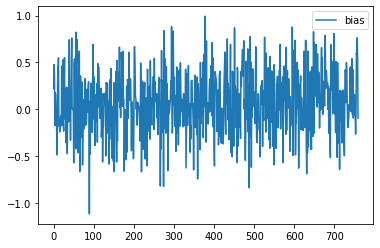

bias_11: [0.23932218], bias_51: [0.28198548]
gamma0.5 and lambda0.01 variance: 0.08545595061498366
0


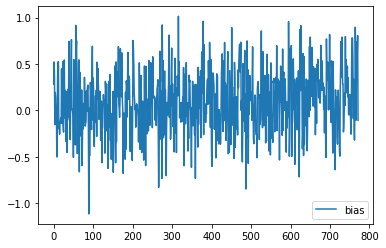

bias_11: [0.24496298], bias_51: [0.27981524]
gamma0.5 and lambda0.25 variance: 0.08620299490329682
0


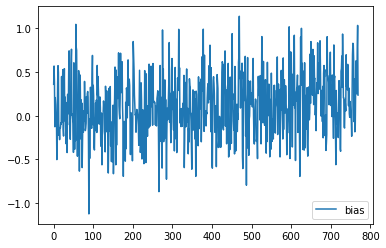

bias_11: [0.2614352], bias_51: [0.28342148]
gamma0.5 and lambda0.5 variance: 0.09085841666305308
0


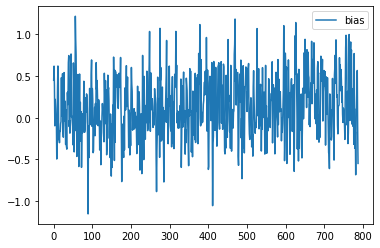

bias_11: [0.29029033], bias_51: [0.28061065]
gamma0.5 and lambda0.75 variance: 0.1070064411095233
0


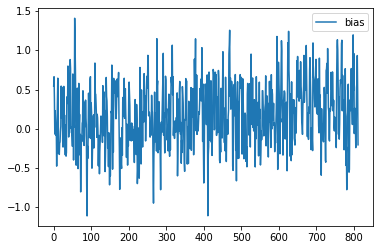

bias_11: [0.32154888], bias_51: [0.28278964]
gamma0.5 and lambda0.99 variance: 0.12756363933535284
1


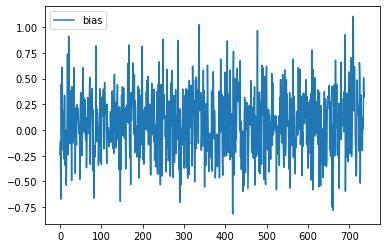

bias_11: [0.25494038], bias_51: [0.30191121]
gamma0.5 and lambda0.01 variance: 0.09508734458048884
1


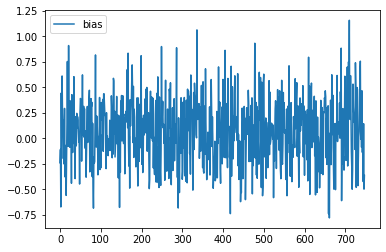

bias_11: [0.25313912], bias_51: [0.29444672]
gamma0.5 and lambda0.25 variance: 0.09510185801351341
1


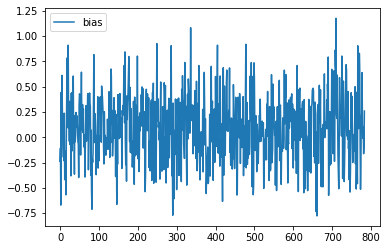

bias_11: [0.24699784], bias_51: [0.28846632]
gamma0.5 and lambda0.5 variance: 0.09088856234910837
1


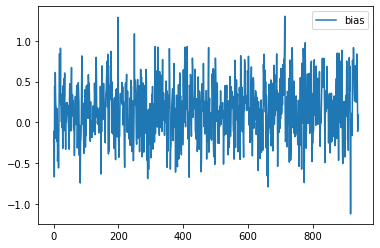

bias_11: [0.26113772], bias_51: [0.25737102]
gamma0.5 and lambda0.75 variance: 0.1134259773516548
1


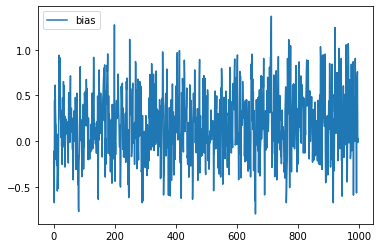

bias_11: [0.28012483], bias_51: [0.24095575]
gamma0.5 and lambda0.99 variance: 0.11022398772169426
2


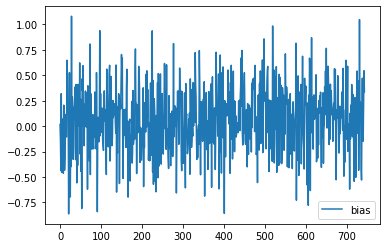

bias_11: [0.23084893], bias_51: [0.26413551]
gamma0.5 and lambda0.01 variance: 0.09266151903828884
2


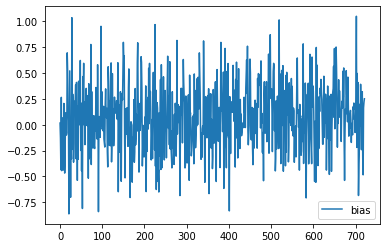

bias_11: [0.22269919], bias_51: [0.26461569]
gamma0.5 and lambda0.25 variance: 0.08604956571770975
2


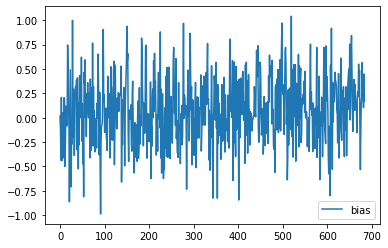

bias_11: [0.21549281], bias_51: [0.28155805]
gamma0.5 and lambda0.5 variance: 0.08001034713672402
2


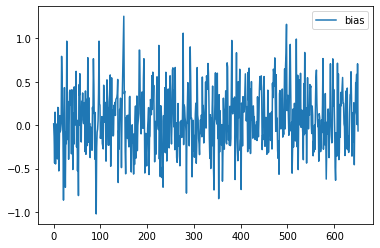

bias_11: [0.24969075], bias_51: [0.24230536]
gamma0.5 and lambda0.75 variance: 0.08763876445151941
2


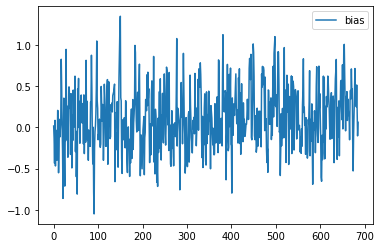

bias_11: [0.26192556], bias_51: [0.24941768]
gamma0.5 and lambda0.99 variance: 0.09381917622762213
3


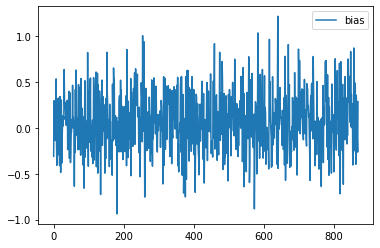

bias_11: [0.23417147], bias_51: [0.25820589]
gamma0.5 and lambda0.01 variance: 0.08898309274993356
3


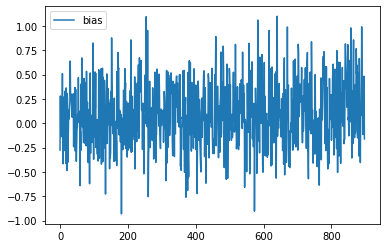

bias_11: [0.24208424], bias_51: [0.25523672]
gamma0.5 and lambda0.25 variance: 0.09442782159859707
3


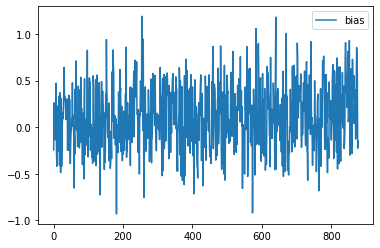

bias_11: [0.23842709], bias_51: [0.26101155]
gamma0.5 and lambda0.5 variance: 0.09704583297183465
3


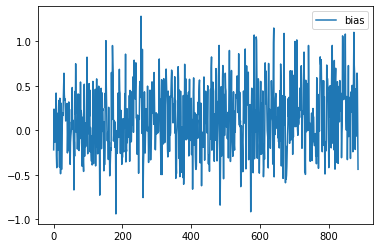

bias_11: [0.25127516], bias_51: [0.26387032]
gamma0.5 and lambda0.75 variance: 0.09831309186456032
3


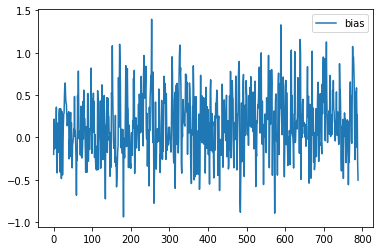

bias_11: [0.25350396], bias_51: [0.28670374]
gamma0.5 and lambda0.99 variance: 0.09700258727728686
4


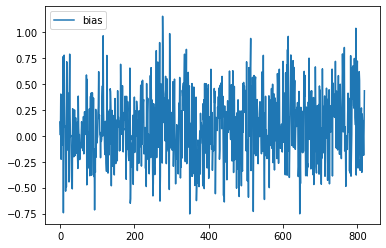

bias_11: [0.24151153], bias_51: [0.28580354]
gamma0.5 and lambda0.01 variance: 0.09710111104367605
4


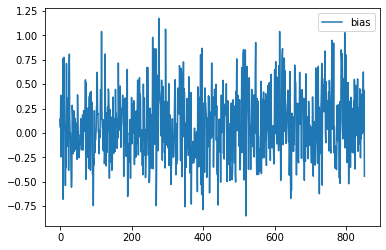

bias_11: [0.24297762], bias_51: [0.25269491]
gamma0.5 and lambda0.25 variance: 0.0883582545367183
4


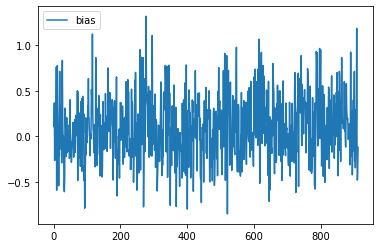

bias_11: [0.25071696], bias_51: [0.24586293]
gamma0.5 and lambda0.5 variance: 0.09370714545830633
4


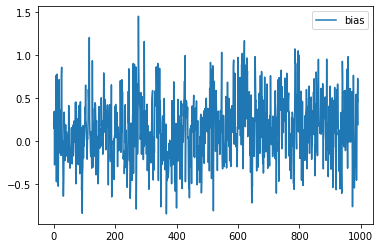

bias_11: [0.25701958], bias_51: [0.27315125]
gamma0.5 and lambda0.75 variance: 0.10249049527970656
4


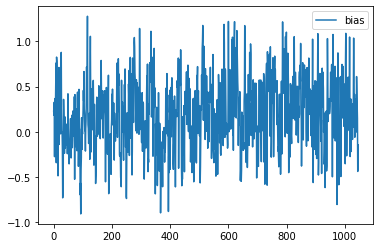

bias_11: [0.29628769], bias_51: [0.26260787]
gamma0.5 and lambda0.99 variance: 0.1059339669925224
5


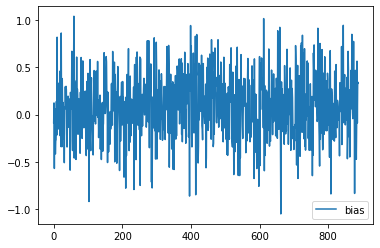

bias_11: [0.25025773], bias_51: [0.29566998]
gamma0.5 and lambda0.01 variance: 0.08263546736741624
5


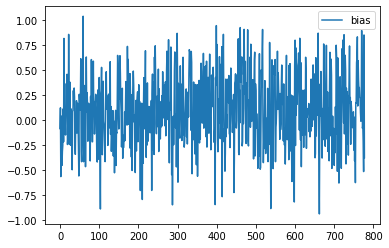

bias_11: [0.26892803], bias_51: [0.29218486]
gamma0.5 and lambda0.25 variance: 0.10342035630758276
5


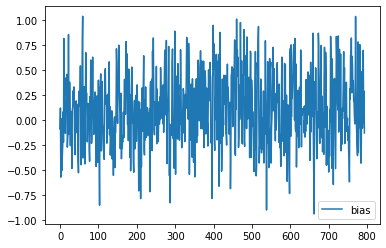

bias_11: [0.28614451], bias_51: [0.28852529]
gamma0.5 and lambda0.5 variance: 0.11057731951989001
5


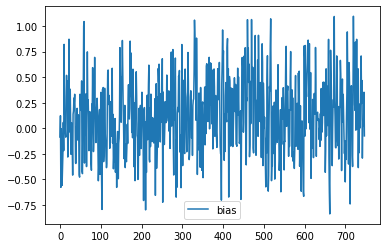

bias_11: [0.30229276], bias_51: [0.28932198]
gamma0.5 and lambda0.75 variance: 0.11765411896945391
5


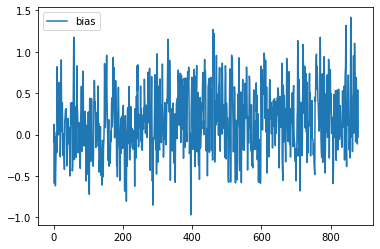

bias_11: [0.31524767], bias_51: [0.28313769]
gamma0.5 and lambda0.99 variance: 0.1311159942140008
6


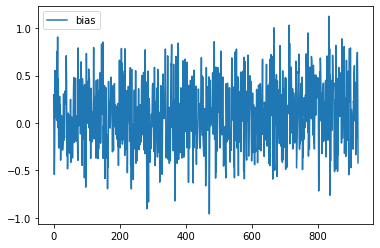

bias_11: [0.2472874], bias_51: [0.32771926]
gamma0.5 and lambda0.01 variance: 0.09326678104490149
6


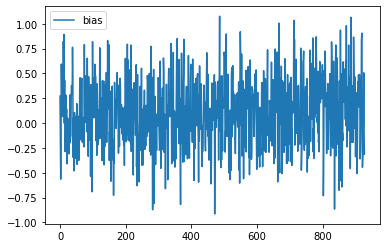

bias_11: [0.24025334], bias_51: [0.31826034]
gamma0.5 and lambda0.25 variance: 0.09108614339101871
6


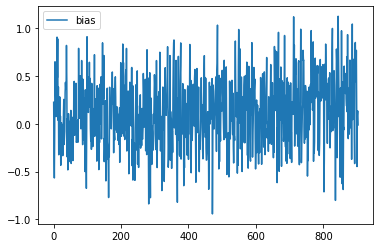

bias_11: [0.25248704], bias_51: [0.31390064]
gamma0.5 and lambda0.5 variance: 0.0954950270692369
6


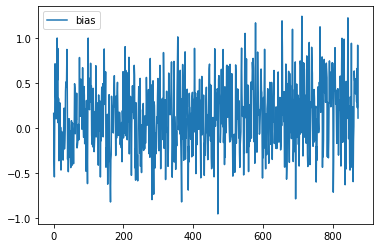

bias_11: [0.27258439], bias_51: [0.31793353]
gamma0.5 and lambda0.75 variance: 0.10488814408043716
6


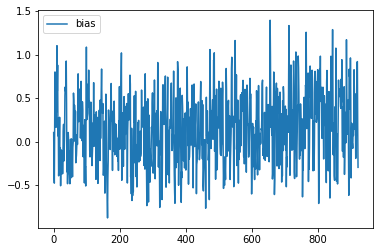

bias_11: [0.3029351], bias_51: [0.32592809]
gamma0.5 and lambda0.99 variance: 0.11997409876470211
7


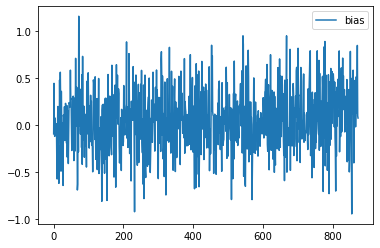

bias_11: [0.26175431], bias_51: [0.2840723]
gamma0.5 and lambda0.01 variance: 0.1086814477010011
7


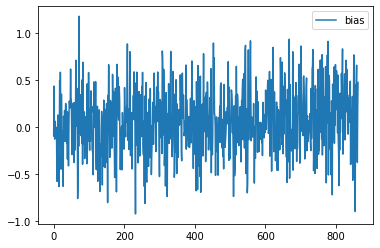

bias_11: [0.25512132], bias_51: [0.27686241]
gamma0.5 and lambda0.25 variance: 0.10667924435498786
7


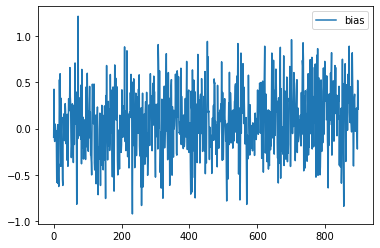

bias_11: [0.26143831], bias_51: [0.27408016]
gamma0.5 and lambda0.5 variance: 0.10445063130037596
7


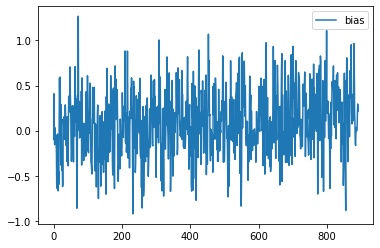

bias_11: [0.26857731], bias_51: [0.26429969]
gamma0.5 and lambda0.75 variance: 0.10862518820270413
7


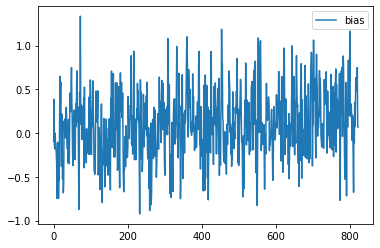

bias_11: [0.28367803], bias_51: [0.26505673]
gamma0.5 and lambda0.99 variance: 0.11994060878977397
8


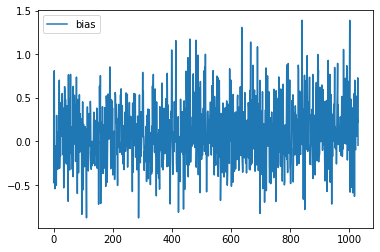

bias_11: [0.26844206], bias_51: [0.26238684]
gamma0.5 and lambda0.01 variance: 0.10508909294794683
8


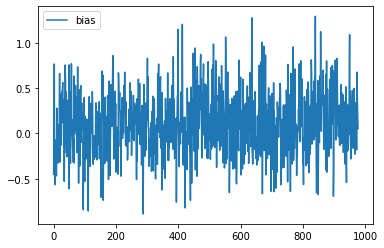

bias_11: [0.27163016], bias_51: [0.26768464]
gamma0.5 and lambda0.25 variance: 0.09730440021450831
8


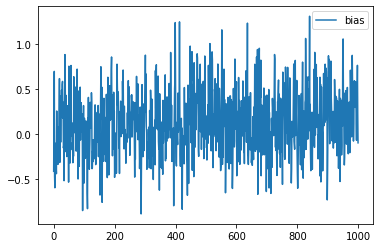

bias_11: [0.27728069], bias_51: [0.25647256]
gamma0.5 and lambda0.5 variance: 0.10214611349923064
8


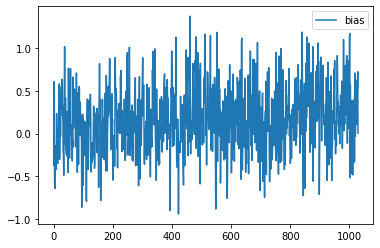

bias_11: [0.27050579], bias_51: [0.28569352]
gamma0.5 and lambda0.75 variance: 0.10467305673805184
8


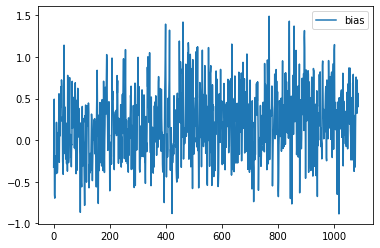

bias_11: [0.33001619], bias_51: [0.27129496]
gamma0.5 and lambda0.99 variance: 0.14365865319292145
9


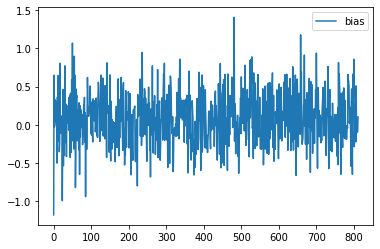

bias_11: [0.23389888], bias_51: [0.28239005]
gamma0.5 and lambda0.01 variance: 0.10076305244706205
9


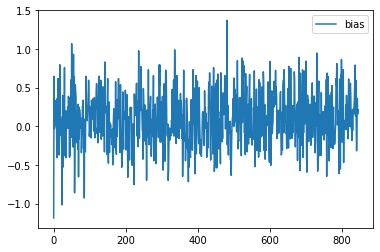

bias_11: [0.24164973], bias_51: [0.27381376]
gamma0.5 and lambda0.25 variance: 0.09261253305157503
9


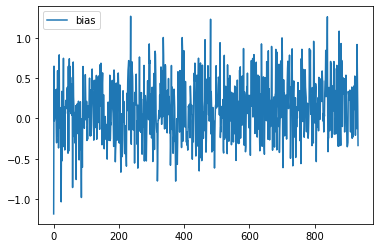

bias_11: [0.25989309], bias_51: [0.25250486]
gamma0.5 and lambda0.5 variance: 0.10799280401318563
9


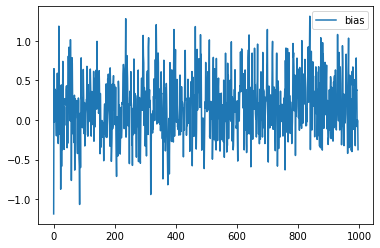

bias_11: [0.27447619], bias_51: [0.247832]
gamma0.5 and lambda0.75 variance: 0.10994231516742689
9


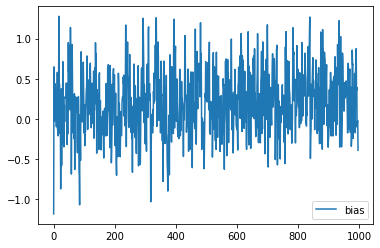

bias_11: [0.30611807], bias_51: [0.26248422]
gamma0.5 and lambda0.99 variance: 0.12725005214464558
nstep: 16	time elapsed: 28s


In [30]:
FLAG_LEARN_VPI = True
value_features = tabular_features
policy_features = tabular_features

tic = time.time()
exp_data1 = dict()
print('Starting the experiments. Estimated time to completion: 1000 seconds')
for nstep in nstep_list: 
    print("nstep: {}".format(nstep))
    exp_data1[nstep] = dict()
    for stepsize in stepsize_list:
        policy_stepsize = stepsize
        value_stepsize = stepsize

        dat = run_experiment(num_runs, num_episodes,
                             P, r, start_state, terminal_states,
                             num_actions, policy_features, value_features,
                             policy_stepsize, value_stepsize, nstep, lambdas, gamma, 
                             FLAG_BASELINE, FLAG_LEARN_VPI, reward_noise)
        
        exp_data1[nstep][stepsize] = dat
    print('nstep: {}\ttime elapsed: {:.0f}s'.format(nstep, time.time() - tic)) 